In [1]:
# Import numpy and scipy for math
import numpy as np
import scipy.optimize as sco

# Import matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# FIgure 1: Free energy landscape of Flory-Huggins polymer solution

## Polymer length N, Flory-Huggins parameter $\chi$, and the functions for free energy and its 1st and 2nd derivatives

In [2]:
# Polymer length
N = 3  

# The critical point in a FH model only depends on the polymer length
xc = 1/(np.sqrt(N) + 1)   # critical volume fraction 
chic = (np.sqrt(N) + 1)**2 /(2 * N)  # critical FH interaction parameter
print('xc =', xc, ' , chic =', chic)


# Define relevant functions
def fFH(x, chi):
    """
    Free energy of a single-phase polymer solution (or a single-phase region in a solution)
    
    :param x: polymer volume fraction
    :param chi: FH interaction parameter 
    """
    return x * np.log(x) / N + (1-x)*np.log(1-x) + chi*x*(1-x)

def dfFH(x, chi):
    """
    1st derivative with respect to volume fraction x of the free energy of the single-phase 
    polymer solution (or a single-phase region in a solution)
    
    :param x: polymer volume fraction
    :param chi: FH interaction parameter 
    """
    return (np.log(x) + 1)/N - (np.log(1-x) + 1) + chi * (1-2*x)

def ddfFH(x, chi):
    """
    2nd derivative with respect to volume fraction x of the free energy of the single-phase 
    polymer solution (or a single-phase region in a solution)
    
    :param x: polymer volume fraction
    :param chi: FH interaction parameter 
    """
    return 1/N/x + 1/(1-x) - 2 * chi 


def fall(x, chi, x0):
    """
    System free energy of a two-phase polymer solution
    
    :param x: two volume fractions of the polymers in each of the two phaases, respectively
    :param chi: FH interaction parameter
    :param x0: the bulk volume fraction, i.e., the averaged polymer volume fraction of the system
    """
    x1, x2 = x[0], x[1]
    v = (x0-x2)/(x1-x2)  # volume ratio of the first phase (i.e., the phase with volume fraction x1)
    
    return v*fFH(x1,chi) + (1-v)*fFH(x2, chi)

def Jall(x, chi, x0):
    """
    A three-dimensional Jacobian vector of the system free energy of a two-phase polymer solution
    Built for minimizing the fall function defined above. When fall achieves its minimum, the corresponding x
    volume fractions will result in Jall = 0 at all its three dimensions
    
    :param x: two volume fractions of the polymers in each of the two phaases, respectively
    :param chi: FH interaction parameter
    :param x0: the bulk volume fraction, i.e., the averaged polymer volume fraction of the system
    """    
    x1, x2 = x[0], x[1]
    v = (x0-x2)/(x1-x2)
    f1 = fFH(x1, chi)
    f2 = fFH(x2, chi)
    df1 = dfFH(x1, chi)
    df2 = dfFH(x2, chi)
    
    return np.array([-v/(x1-x2)*(f1-f2) + v*df1, 
                     (1-v)/(x1-x2)*(f2-f1)+(1-v)*df2])


def ps_calc(chi, x0):
    """
    Minimizing the overall free energy of the polymer solution. First find the two spinodal phase separation
    points, and then search the binodal points outside the spinodal decomposition region
    
    :param chi: FH interaction parameter
    :param x0: the bulk volume fraction, i.e., the averaged polymer volume fraction of the system
    """
    
    # Find spinodal points via brent-h root finding algorithm
    sp1 = sco.brenth(ddfFH, 1e-5, x0, args=(chi,))  
    sp2 = sco.brenth(ddfFH, x0, 0.99, args=(chi,))
    
    # Minimize system free erengy fall defined above to obtain the binodal volume fractions x
    # via L-BFGS-B algorithm
    bis = sco.minimize(fall, x0=(0.01,0.9), args=(chi,x0), 
                       jac=Jall, bounds=((1e-5, sp1),(sp2,0.99)), method='L-BFGS-B')
    return sp1, sp2, bis.x[0], bis.x[1]



xc = 0.36602540378443865  , chic = 1.2440169358562925


## Find the phase separation points at a given $\chi$ and a given N

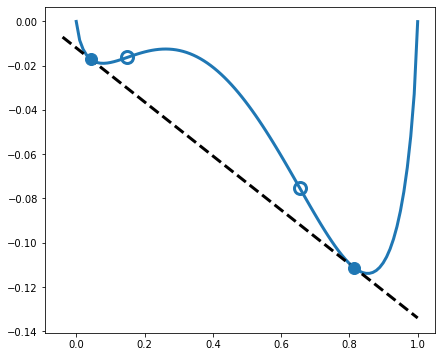

In [3]:
# Assign the FH parameter of interest
chi_t = 1.7

# Find the two spinodal phase separation points (sp1_t, sp2_t) 
# and the two binodal phase separation points (bi1_t, bi2_t)
sp1_t, sp2_t, bi1_t, bi2_t = ps_calc(chi_t, xc)


############################################# Plot the figure #############################################

# Data points of free energy versus volume fractions 
xx = np.linspace(1e-5,1-1e-5, 100)  # volume fractions
yy = [fFH(xxx,chi_t) for xxx in xx]  # the corresponding free energies

# Plot the free energy curve
plt.figure(figsize=(7,6))
plt.plot(xx, yy, 'C0-', lw=3)

# The tangent line function 
ftan = lambda x: (fFH(bi2_t,chi_t) - fFH(bi1_t,chi_t))/(bi2_t-bi1_t) * ( x - bi1_t ) + fFH(bi1_t, chi_t)


# Plot the tangent line and the phase separation points
xt = np.linspace(-0.04,1, 100)
plt.plot( xt, [ftan(t) for t in xt] , 'k--', lw=3)  # tangent line
plt.plot( [bi1_t, bi2_t],  [fFH(bi1_t,chi_t), fFH(bi2_t,chi_t)] , 'o', ms=12)  # binodal points
plt.plot( [sp1_t, sp2_t],  [fFH(sp1_t,chi_t), fFH(sp2_t,chi_t)] , 'o',ms=12,  
         mew=3, color='C0', fillstyle='none')  # spinodal points


#plt.savefig('FHscheme1.eps', transparent=True)

## Calculate the whole $\chi$-dependent phase diagram for the given N

In [4]:
# Prepare the to-be-investigated chi values
n_plot = 500  # total number of investigated chi values
chiall = np.linspace(chic*1.001, 3, n_plot)  # make an array for all of the chi's

# Calculate the phase separation points at each of the chi's one by one
ps_plot_t = []
for chi in chiall:
    sp1, sp2, bi1, bi2 = ps_calc(chi, xc)
    ps_plot_t.append([sp1,sp2, bi1,bi2])

# Organize the data format
pp = np.array(ps_plot_t).T.tolist()
pp.append(chiall.tolist())
ps_plot = np.array(pp).T

## Plot the phase diagram

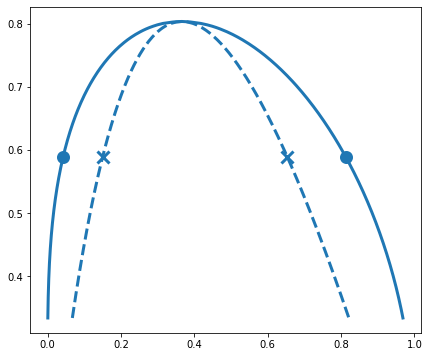

In [5]:
plt.figure(figsize=(7,6))


# Plot the spinodal boundary
plt.plot(ps_plot[::-1,0].tolist()+[xc]+ps_plot[:,1].tolist(), 
         1/np.array(ps_plot[::-1,-1].tolist()+[chic]+ps_plot[:,-1].tolist()), '--C0', lw=3)

# Plot the binodal boundary
plt.plot(ps_plot[::-1,2].tolist()+[xc]+ps_plot[:,3].tolist(), 
         1/np.array(ps_plot[::-1,-1].tolist()+[chic]+ps_plot[:,-1].tolist()), '-C0', lw=3)

# Plot the spinodal points calculated at a chi selected above
plt.plot([sp1_t, sp2_t], [1/chi_t, 1/chi_t], 'xC0', ms=12, mew=3)

# Plot the binodal points calculated at a chi selected above
plt.plot([bi1_t, bi2_t], [1/chi_t, 1/chi_t], 'oC0', ms=10, mew=3)

#plt.savefig('FHscheme2.eps', transparent=True)

# FIgure 2: Free energy landscape of a three-component solution

## Calculate the free energy and the spinodal decomposition region of a solution of two polymers and solvent

In [6]:
### Two-polymer solution has a lot of free parameters, here we implement some symmetry to simplify the discussion:

### 1. Consider the two polymers have the same length, N1 = N2 = N
N = 3 

### 2. Consider the 1-1 and 2-2 polymer-polymer interactions are the same, chi11 = chi22 = t * chi12
t = 0.3  


########################################### Relevant functions ###########################################
def fFH2d(x, y, chi):
    """
    Free energy of a single-phase polymer solution (or a single-phase region in a solution)
    
    :param x: volume fraction of polymer1
    :param y: volume fraction of polymer2
    :param chi: FH interaction parameter between the two different polymers 
    """
    f = x * np.log(x) / N + y * np.log(y) / N + (1-x-y + (x+y>1))*np.log(1-x-y + (x+y>1)) - chi*x*y \
        + chi*t*x*(1-x) + chi*t*y*(1-y) \
        - (x+y) * ( 1/N*np.log(1/2) - chi/4 + chi*t/2 * 0.8)
    return f * (x+y<1) -100*(x+y>=1) 
    
def ddfFH2d(x, y, chi):
    """
    Determinant of the Hessian matrix a single-phase polymer solution (or a single-phase region in a solution)
    
    :param x: volume fraction of polymer1
    :param y: volume fraction of polymer2
    :param chi: FH interaction parameter between the two different polymers 
    """ 
    ddxx = 1/N/x + 1/(1-x-y) - 2*t*chi
    ddyy = 1/N/y + 1/(1-x-y) - 2*t*chi
    ddxy = 1/(1-x-y) - chi
    return (ddxx * ddyy - ddxy * ddxy) 

### The coefficient of the linear term in the free energy 

In [7]:
( 1/N*np.log(1/2) - 3.8/4 + 3.8*t/2 * 0.8)

-0.7250490601866484

## Find the region with a negative Hessian determinant, which is just the region of spinodal decomposition

In [8]:
# Define the grid search region, n2d x n2d grid points covering volume fractions from pmin to pmax
n2d = 500 
chi_t_2d = 3.8
pmin, pmax = 0.005, 0.499
phi1 = np.linspace(pmin, pmax,n2d)
phi2 = np.linspace(pmin, pmax,n2d)


# Loop through all the grid points and find the phase boundary, i.e., where Hessian determinant equals zero
phi_2d_sp = []
phi_bound = []
ddfall = []
for i in range(n2d):
    for j in range(n2d):
        
        # Calculate the Hessian determinant of this grid point
        ddf = ddfFH2d(phi1[i], phi2[j], chi_t_2d)

        if phi1[i] + phi2[j] < 1:
            if ddf < 0:
                # If this grid point has a negative Hessian determinant, count it as a spinodal point
                phi_2d_sp.append([phi1[i], phi2[j]])
                if ddfall[-1][2] > 0:
                    # If the previous grid point has a positive Hessian determinant, then this point is close 
                    # enough to the spinodal the boundary -- count the average of the two as a boundary point
                    phi_bound.append([(phi1[i] + ddfall[-1][0])/2, (phi2[j]+ ddfall[-1][1])/2])
            if ddf > 0 and ddfall:
                # If this grid point has a positive Hessian determinant, do not count it as a spinodal point
                if ddfall[-1][2]<0:
                    # If the previous grid point has a negative Hessian determinant, then this point is close 
                    # enough to the spinodal the boundary -- count the average of the two as a boundary point
                    phi_bound.append([(phi1[i] + ddfall[-1][0])/2, (phi2[j]+ ddfall[-1][1])/2])
        
        # Record the Hessian determinant value of the grid point 
        ddfall.append([phi1[i], phi2[j], ddf] )
        
        
# Organize the data format
phi_2d_sp = np.array(phi_2d_sp)        
phi_bound = np.array(phi_bound)
ddfall = np.array(ddfall)

## Plot the spinodal region in blue and the boundary points in black

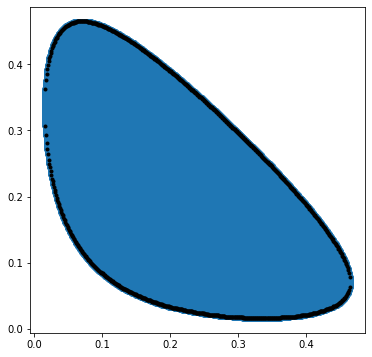

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(phi_2d_sp[:,0], phi_2d_sp[:,1])
plt.plot(phi_bound[:,0], phi_bound[:,1], '.k')

## Connect the black points to make a smooth contour

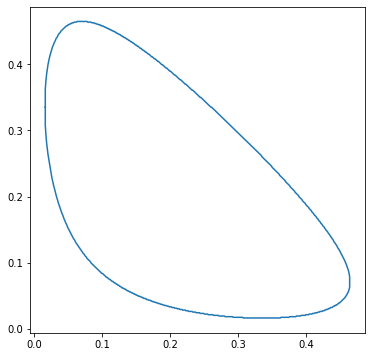

In [10]:
phi_bound_left = phi_bound[::2,:]
phi_bound_right = phi_bound[1::2,:]

phi_bound_all = [((phi_bound_left[0,:]+phi_bound_right[0,:])/2).tolist()] \
                + phi_bound_right.tolist() \
                + phi_bound_left[::-1].tolist() \
                + [((phi_bound_left[0,:]+phi_bound_right[0,:])/2).tolist()]

phi_bound_all = np.array(phi_bound_all)

plt.figure(figsize=(6,6))
plt.plot(phi_bound_all[:,0], phi_bound_all[:,1])

## Few grid points are plotted below for pedagogical purpose

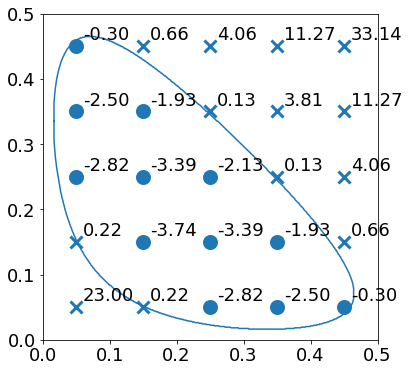

In [11]:
plt.figure(figsize=(6,6))
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


p1 = [0.05, 0.15, 0.25, 0.35, 0.45]
p2 = [0.05, 0.15, 0.25, 0.35, 0.45]
for i in p1:
    for j in p2:
        ddf = ddfFH2d(i, j, chi_t_2d)
        dot = 'o' if ddf < 0 else 'x'
        plt.plot(i, j, dot, color='C0', ms=12, mew=3)
        plt.annotate('{0:.2f}'.format(ddf), xy=(i+0.01, j+0.01), fontsize=18)
        
plt.plot(phi_bound_all[:,0], phi_bound_all[:,1])
#plt.savefig('fh_contour_scheme.pdf', transparent=True)

## Free energy landscape data formatting

In [12]:
X, Y = np.meshgrid(phi1, phi2)
Z = fFH2d(X,Y,chi_t_2d)

## 3D-plot the free energy values at the grid points

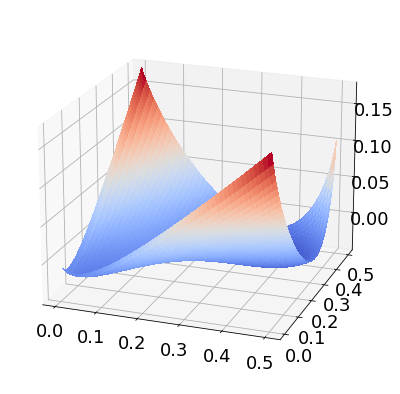

In [13]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%matplotlib inline


fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7,7))
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.zaxis.set_tick_params(labelsize=18)
ax.view_init(elev=20, azim=-70)

#plt.savefig('3d_profile.pdf', transparent=True)

## Heat map stacked with the contour of spinodal phase separation region

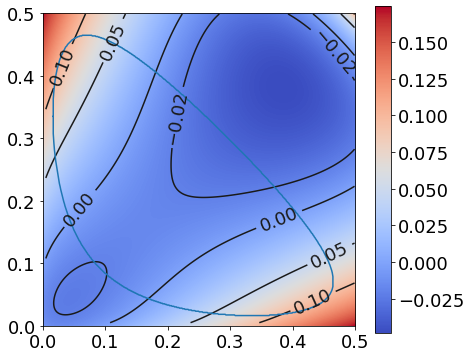

In [14]:
fig = plt.figure(figsize=(7,6))

plt.imshow(Z[::-1,:],  cmap=cm.coolwarm,
          extent=[0,0.5,0,0.5])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

CS = plt.contour(X, Y, Z, levels=[-0.02, 0,0.05,0.1], colors=['0.1','0.1','0.1','0.1'])
# manual_locations = [
#     (-1, -1.4), (-0.62, -0.7), (-2, 0.5), (1.7, 1.2)]
plt.clabel(CS, inline=True, fontsize=18)#, manual=manual_locations)


plt.plot(phi_bound_all[:,0], phi_bound_all[:,1])
# plt.savefig('fh_contour.pdf', transparent=True)